## Background
In this blog post I will use fastai to train a model that predicts more than one target for the Kaggle Titanic dataset.

I've referenced the notebook [Multi-target: Road to the Top, Part 4](https://www.kaggle.com/code/jhoward/multi-target-road-to-the-top-part-4/notebook) by Jeremy Howard as well as a derivative notebook [Small models + Multi-targets](https://www.kaggle.com/code/archietram/small-models-multi-targets/notebook) by Kaggle user Archie Tram (in which he creates a test `DataLoader` to get predictions from the model).

## Plan of Attack

### Creating `DataLoaders`

In Jeremy's notebook, he is classifying images of plants with two targets: disease and variety of plant.

He creates his `DataLoaders` object as follows:

```python
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock,CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [parent_label,get_variety],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(trn_path)

```

There are three `blocks`: 1 input `ImageBlock` and 2 output `CategoryBlock`s. The model gets the outputs with `parent_label` (for the disease) and a custom function `get_variety` (which grabs the `variety` column value of the given image from a `DataFrame`).

In my use case, I will have to follow a similar approach, albeit catered to tabular data.

### Calculating Losses

Jeremy calculates loss as the sum of the following:

- Cross-Entropy loss of the disease inputs
- Cross-Entropy loss of the variety inputs

I'll follow a similar approach, except if I use continuous variables as targets I'll use MSE instead of Cross-Entropy.

### Calculating Metrics

Similar to the loss calculation, I'll combine the calculation of the metric for each of the two targets. For continuous variables, I'll use RMSE.

## Training a Multi-Target Model

With a rough plan outlined, I'll start the training process with loading and cleaning the Titanic dataset.

### Load and Clean Data

In [1]:
from fastai.tabular.all import *

In [3]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path("../input/titanic")
else:
  path = Path('titanic')
  if not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 6.18MB/s]

In [5]:
# load the training data and look at it
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
# feature engineering
def add_features(df):
  df['LogFare'] = np.log1p(df['Fare'])
  df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
  df['Family'] = df.SibSp+df.Parch
  df['Alone'] = df.Family == 0
  df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
  df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
  df['Title'] = df.Title.map(dict(Mr="Mr", Miss="Miss", Mrs="Mrs", Master="Master"))

In [7]:
# add the features to our dataframe
add_features(df)

In [8]:
# view the topmost row of the modes DataFrame
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
LogFare                   2.202765
Deck                           ABC
Family                         0.0
Alone                         True
TicketFreq                     1.0
Title                           Mr
Name: 0, dtype: object

In [9]:
# fill missing data with the column's mode
df.fillna(modes, inplace=True)

In [10]:
# check that we no longer have missing data
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
LogFare        0
Deck           0
Family         0
Alone          0
TicketFreq     0
Title          0
dtype: int64

In [11]:
# create training and validation index lists
splits = RandomSplitter(seed=42)(df)

### Create `DataLoaders`

I'll take most of the code from the [Why you should use a framework](https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework) notebook by Jeremy, with the following changes:

- Remove `"Age"` from `cont_names` and move it to `y_names` along with `"Survived"` which will be our two targets.
- Set `n_out=2` for the `RegressionBlock`.

I'll treat both targets as a regression, as I wasn't able to provide two `DataBlock`s for `y_block`.

Since I've filled in missing values manually, I have removed the `FillMissing` item from `procs`.

In [12]:
# create dataloaders object
dls = TabularPandas(
    df,
    splits=splits,
    procs=[Categorify, Normalize],
    cat_names=["Sex", "Pclass", "Embarked", "Deck", "Title"],
    cont_names=["SibSp", "Parch", "LogFare", "Alone", "TicketFreq", "Family"],
    y_names=["Age", "Survived"],
    y_block=RegressionBlock(n_out=2)
).dataloaders(path=".")

In [13]:
dls.show_batch()

,Sex,Pclass,Embarked,Deck,Title,SibSp,Parch,LogFare,Alone,TicketFreq,Family,Age,Survived
0,male,1,S,ABC,Mr,1.000000e+00,-9.897945e-09,3.970292,2.458140e-08,2.0,1.000000e+00,42.0,0.0
1,male,3,S,ABC,Mr,1.689237e-09,-9.897945e-09,2.230014,1.000000e+00,1.0,-1.856774e-08,18.0,0.0
2,male,2,S,ABC,Mr,1.000000e+00,2.000000e+00,3.358638,2.458140e-08,3.0,3.000000e+00,36.0,0.0
3,male,3,C,ABC,Mr,1.000000e+00,1.000000e+00,2.107689,2.458140e-08,1.0,2.000000e+00,17.0,0.0
4,male,3,S,ABC,Mr,1.689237e-09,-9.897945e-09,2.351375,1.000000e+00,1.0,-1.856774e-08,28.0,0.0
5,female,3,S,ABC,Mrs,1.000000e+00,4.000000e+00,3.363842,2.458140e-08,6.0,5.000000e+00,45.0,0.0
6,male,3,S,ABC,Mr,1.689237e-09,-9.897945e-09,2.324836,1.000000e+00,1.0,-1.856774e-08,23.0,0.0
7,female,3,C,ABC,Mrs,1.689237e-09,-9.897945e-09,2.107178,1.000000e+00,1.0,-1.856774e-08,24.0,1.0
8,male,3,S,ABC,Mr,1.689237e-09,-9.897945e-09,2.188856,1.000000e+00,1.0,-1.856774e-08,39.0,1.0
9,female,2,C,ABC,Mrs,1.000000e+00,-9.897945e-09,3.436269,2.458140e-08,2.0,1.000000e+00,14.0,1.0


### Create Loss Function

If I understand correctly, we will get 2 columns of predictions, and two variables of targets to compute the loss with:

In [24]:
def age_loss(pred, yb): return F.mse_loss(pred[:,0], yb[:,0])
def survived_loss(pred, yb): return F.mse_loss(pred[:,1], yb[:,1])

def combine_loss(pred, yb): return age_loss(pred, yb) + survived_loss(pred, yb)

### Create Metric Function

I'll create an RMSE function for each target variable:

In [25]:
def age_rmse(pred, yb): return torch.sqrt(F.mse_loss(pred[:,0], yb[:,0]))
def survived_rmse(pred, yb): return torch.sqrt(F.mse_loss(pred[:,1], yb[:,1]))

rmse_metrics = (age_rmse, survived_rmse)

In [37]:
learn = tabular_learner(dls, loss_func=combine_loss, metrics=rmse_metrics, layers=[10,10], n_out=2)

Most times that I ran the learning rate finder, the loss was steadily increasing from the get-go. I randomly came across the following learning rate regime which looks more stable, so I'll use the given value.

SuggestedLRs(slide=6.309573450380412e-07, valley=0.14454397559165955)

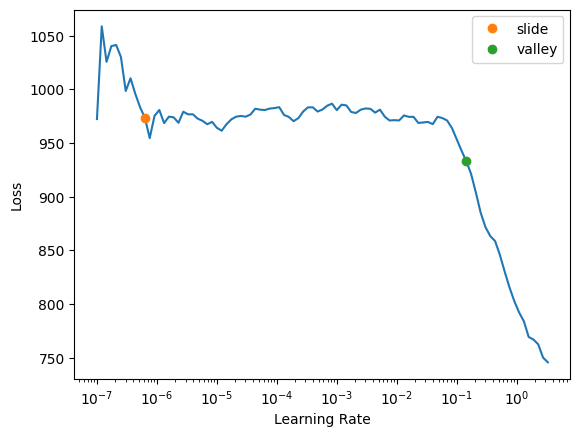

In [38]:
learn.lr_find(suggest_funcs=(slide, valley))

In [39]:
learn.fit(20, lr=0.1)

epoch,train_loss,valid_loss,age_rmse,survived_rmse,time
0,766.320923,554.657837,23.431234,0.721841,00:00
1,460.486603,170.207932,13.030014,0.590790,00:00
2,335.931213,132.264999,11.456180,0.649899,00:00
3,265.317535,116.719322,10.778342,0.477045,00:00
4,221.392242,121.840828,11.004195,0.441827,00:00
5,192.420349,132.113815,11.457218,0.472019,00:00
6,173.592255,120.654694,10.943729,0.462033,00:00
7,159.223709,113.375626,10.612040,0.519316,00:00
8,148.853653,114.346222,10.654099,0.484549,00:00
9,140.409439,109.572639,10.437387,0.467927,00:00


After a few epochs, the RMSE values stop improving. The validation loss also fluctuates throughout the training after decreasing for the first three epochs.

### Comparing Predictions to Actuals

Based on how the training went, I'm not expecting this model to be able to predict `Age` and `Survived` very well. I'll use the validation set to get predictions and then calculate accuracy for `Survived` and correlation between actuals vs. predictions for `Age`.

In [43]:
preds, targ = learn.get_preds(dl=dls.valid)

In [47]:
# Survived accuracy
(targ[:,1] == (preds[:,1]>0.5)).float().mean()

tensor(0.6348)

In [58]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

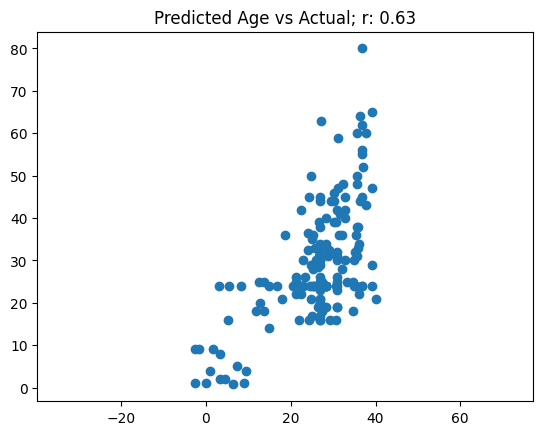

In [59]:
# Age plot
fig, ax = plt.subplots(1)

ax.axis('equal')
plt.title(f'Predicted Age vs Actual; r: {corr(preds[:,0], targ[:,0]):.2f}')
ax.scatter(preds[:,0], targ[:,0]);

The model achieved shoddy accuracy (63%) and an uninspiring correlation between predicted and actual age. The model did particularly poorly in predicting ages above 40.

## Comparing to Single-Target Models

I'm curious to see how the model performs when I train it for single targets. I'll train one regression model for `Age`, another separate regression model for `Survived`, and see how their results compare to the combined two-target model.

### Single Target: Age

In [73]:
# create dataloaders object
age_dls = TabularPandas(
    df,
    splits=splits,
    procs=[Categorify, Normalize],
    cat_names=["Sex", "Pclass", "Embarked", "Deck", "Title"],
    cont_names=["SibSp", "Parch", "LogFare", "Alone", "TicketFreq", "Family"],
    y_names="Age",
    y_block=RegressionBlock()
).dataloaders(path=".")

In [74]:
age_learn = tabular_learner(age_dls, metrics=rmse, layers=[10,10])

I ran the learning rate finder 10 times and got similar charts each time, which tells me that something about this model is more stable than my two-target model.

SuggestedLRs(slide=6.309573450380412e-07, valley=0.0831763744354248)

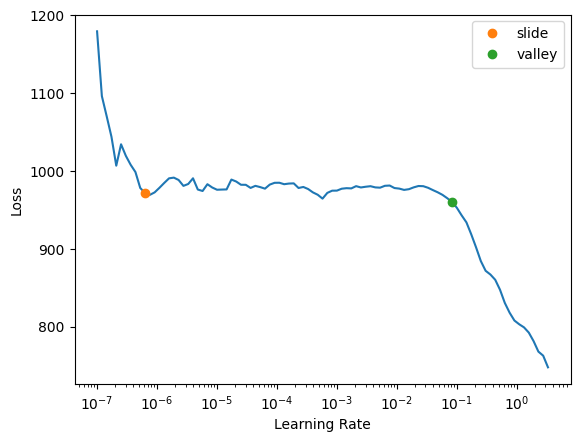

In [84]:
age_learn.lr_find(suggest_funcs=(slide, valley))

In [85]:
age_learn.fit(16, lr=0.1)

epoch,train_loss,valid_loss,_rmse,time
0,781.124268,233.326263,15.275021,00:00
1,454.851532,408.981842,20.223301,00:00
2,328.806274,116.149773,10.777281,00:00
3,263.302643,119.088097,10.912749,00:00
4,219.239166,127.125175,11.274981,00:00
5,190.565811,111.707756,10.569189,00:00
6,171.005737,113.618858,10.659215,00:00
7,157.105713,109.284859,10.453939,00:00
8,146.396072,118.541183,10.887661,00:00
9,138.696716,107.435219,10.365096,00:00


The validation loss also fluctuates in this model's training. The RMSE metric also does not really improve after the first couple of epochs. Similar to last time, I'll plot the predicted age vs actual and calculate the correlation between the two:

In [86]:
age_preds, age_targ = age_learn.get_preds(dl=age_dls.valid)

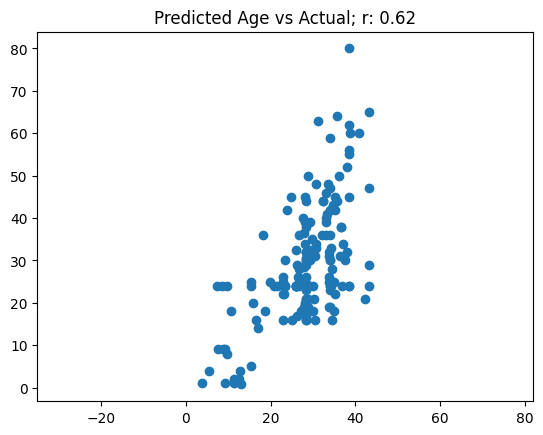

In [87]:
# Age plot
fig, ax = plt.subplots(1)

ax.axis('equal')
plt.title(f'Predicted Age vs Actual; r: {corr(age_preds[:,0], age_targ[:,0]):.2f}')
ax.scatter(age_preds[:,0], age_targ[:,0]);

Surprisingly, the single target Age model does not perform much better than my two-target model. I get a similar correlation, and this model also fails to predict ages above around 40.

### Single Target: Survived

In Jeremy's "Why you should use a framework" notebook, he achieves about an 83% accuracy. I'll use this as a benchmark to compare my model with.

In [88]:
# create dataloaders object
survived_dls = TabularPandas(
    df,
    splits=splits,
    procs=[Categorify, Normalize],
    cat_names=["Sex", "Pclass", "Embarked", "Deck", "Title"],
    cont_names=["SibSp", "Parch", "LogFare", "Alone", "TicketFreq", "Family"],
    y_names="Survived",
    y_block=RegressionBlock()
).dataloaders(path=".")

In [89]:
survived_learn = tabular_learner(survived_dls, metrics=rmse, layers=[10,10])

SuggestedLRs(slide=0.05754399299621582, valley=0.0063095735386013985)

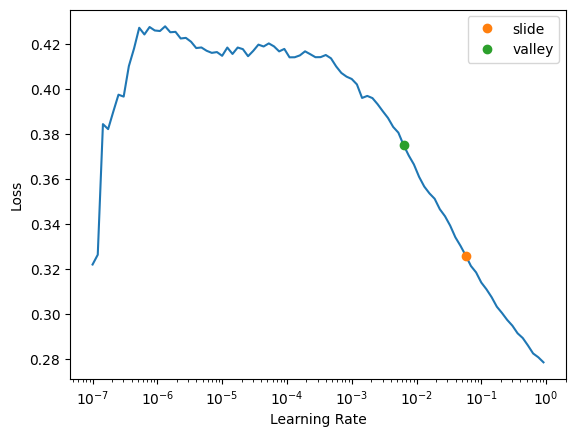

In [91]:
survived_learn.lr_find(suggest_funcs=(slide, valley))

In [92]:
survived_learn.fit(16, lr=0.02)

epoch,train_loss,valid_loss,_rmse,time
0,0.250865,0.240620,0.490530,00:00
1,0.200100,0.214276,0.462899,00:00
2,0.177398,0.150440,0.387866,00:00
3,0.163052,0.135140,0.367615,00:00
4,0.153141,0.131269,0.362311,00:00
5,0.147007,0.133025,0.364726,00:00
6,0.143294,0.132439,0.363922,00:00
7,0.138928,0.131754,0.362979,00:00
8,0.135169,0.128147,0.357976,00:00
9,0.133087,0.125253,0.353910,00:00


In [93]:
survived_preds, survived_targ = survived_learn.get_preds(dl=survived_dls.valid)

In [95]:
(survived_targ == (survived_preds>0.5)).float().mean()

tensor(0.8258)

I get an accuracy of around 83% as well.

## Final Thoughts

Here are my takeaways from this experiment:

- A single-target regression model predicts `Survived` better than `Age`.
- A two-target regression model (`Survived` and `Age`) predicts `Survived` significantly worse than a single-target model (`Survived` only). Something about introducing an output for `Age` decreases the model's performance when predicting survival rate.
- A two-target regression model (`Survived` and `Age`) predicts `Age` with about the same correlation as a single-target model (`Age` only).


Something about this dataset (and how the model learns from it) makes `Age` a poor target for prediction. Perhaps it's the distribution of ages in the dataset, or the relationship with other columns, that makes it harder for the model to predict it accurately.

I'm happy and proud that I was able to run this experiment after failing to overcome some errors the first couple of times I tried to train a two-target model earlier this week.

I hope you enjoyed this blog post!